# Feature Mathching


In [73]:
%matplotlib inline
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
from scipy.signal import correlate2d 
from scipy.ndimage import gaussian_filter  

The goal of this assignment is to create a local feature matching algorithm. 

First we detect interest points (features) in each image (using your Harris corners implementation). 

Then we use some descriptor to describe each of the detected features. 

Finally, the matching process is as follows: It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance function. The closest one (minimum distance) is returned.


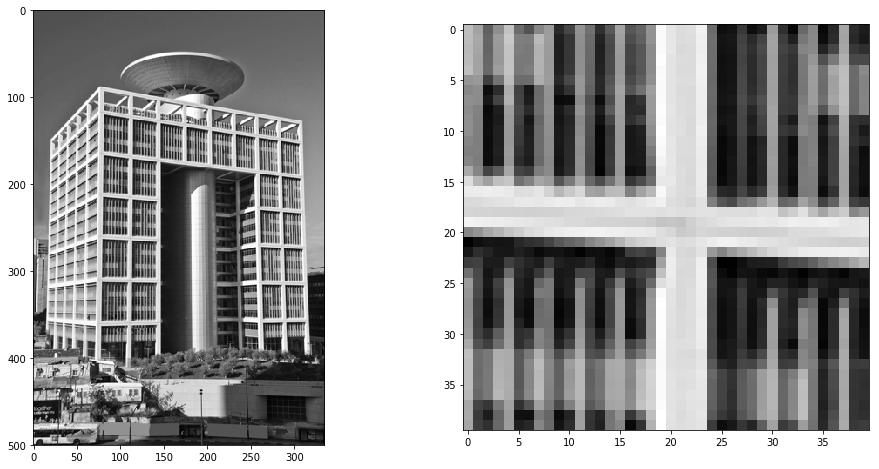

In [74]:
# load some test images

source_img = io.imread('kiria.jpg',as_grey=True)
query_img = source_img[195:235,90:130]


plt.figure(figsize=(16,8))
ax1 = plt.subplot(1,2,1)
ax1.imshow(source_img, cmap='gray',interpolation='nearest')
ax2 = plt.subplot(1,2,2)
ax2.imshow(query_img, cmap='gray',interpolation='nearest')
plt.show()

### 1. Feature Detector

The feature detector uses Harris score with a threshold as a parameter. It detects features with a score above the threshold and uses maxima-supression. 

Note, the detector should discard points that are too close to the boundary of the image (with N being the margin parameter).

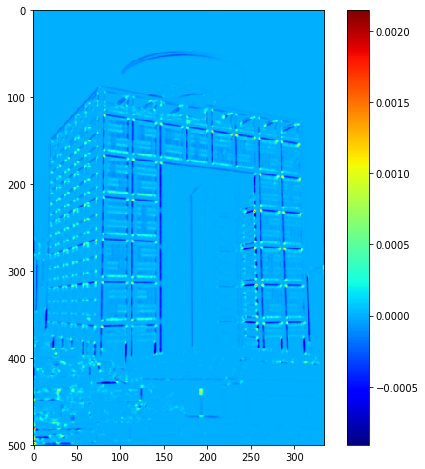

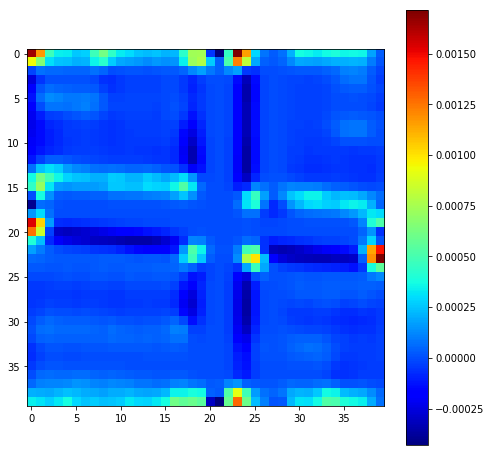

In [75]:
def harris_score (im, sigma):
    
    # sobel gradients
    Sx = np.array([[-1,0,1],
                  [-2,0,2],
                  [-1,0,1]])/8

    Sy = np.array([[-1,-2,-1],
                  [0,0,0],
                  [1,2,1]])/8
    
    # image gradients
    Gx = correlate2d(im,Sx,mode='same')
    Gy = correlate2d(im,Sy,mode='same')
   
    # compute components of the Harris matrix 
    Mxx = gaussian_filter(Gx*Gx,sigma) 
    Mxy = gaussian_filter(Gx*Gy,sigma) 
    Myy = gaussian_filter(Gy*Gy,sigma)
    
    # determinant and trace
    detM = Mxx*Myy - Mxy**2
    trM = Mxx + Myy
    R = detM - 0.06*(trM**2)
    
    return R

R = harris_score(source_img,1)
plt.figure(figsize=(8,8))
plt.imshow(R,cmap='jet')
plt.colorbar()
plt.show()

R = harris_score(query_img,1)
plt.figure(figsize=(8,8))
plt.imshow(R,cmap='jet')
plt.colorbar()
plt.show()

In [76]:
def feature_detector (im, sigma, threshold, N=3):
    R = harris_score(im,sigma)
    
    # your code here:
    
    
    F = R > threshold
    
    # NMS
    is_bigger = True
    for i in range(1,len(F) - 1):
        for j in range(1,len(F[0]) - 1):
            is_bigger = True
            for r in range(-1,2):
                for c in range(-1,2):
                    if(F[i,j] < F[i+r,j+c]):
                        is_bigger = False
            F[i,j] = is_bigger * F[i,j]
            
    F[:N+1,:] = 0
    F[-1 * (N+1):,:] = 0
    F[:,:N+1] = 0
    F[:, -1 * ( N+1): ] = 0
    # (threshold, NMS, and discard points to close to margins)
#     plt.figure(figsize=(8,8))
#     plt.imshow(F,cmap='jet')
#     plt.show()
    return F 

source_img : 1131  features


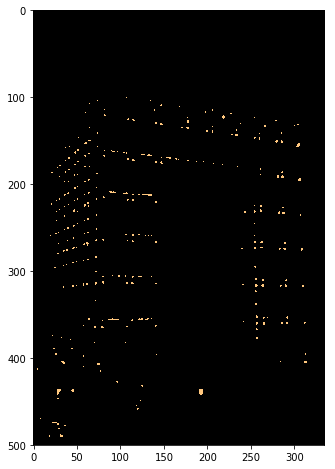

query_img : 26  features


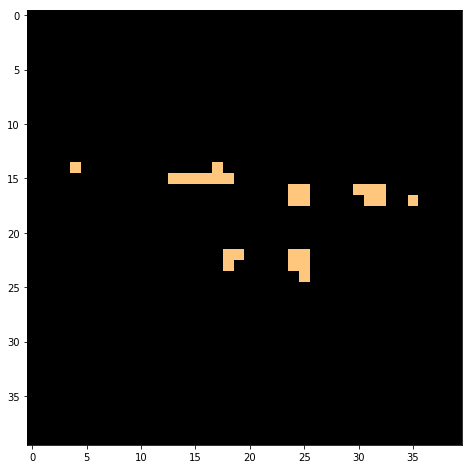

In [77]:
# detect features in the source-image and in the query-image. plot the results
# how many features detected in each image? (print the result)


si = feature_detector(source_img,1,0.000275)
qi = feature_detector(query_img,1,0.000275)


print('source_img :',len(np.nonzero(si)[0]),' features')
plt.figure(figsize=(8,8))
plt.imshow(si, cmap = 'copper')
plt.show()
print('query_img :',len(np.nonzero(qi)[0]),' features')
plt.figure(figsize=(8,8))
plt.imshow(qi, cmap = 'copper')
plt.show()


### 2. Feature Descriptor

We will implement 3 types of descriptors:

- `desc_simple`: is a simple descriptor, a collection of all pixels values, in a square (9x9) patch around the feature.

- `desc_hist`: is a gradients histogram descriptor. first, collect all the gradients in a square (9x9) patch around the feature. then, use `plt.hist` to calculate their oreintations hisogram ($[0-2\pi]$ divided into 6 bins). Use the gradients magnitudes as weights in the histogram.

- `desc_sift` (Bonus): SIFT-like descriptor. first, divide the 9x9 square patch around the feature into 9 sub-patches, each of a 3x3 size. next, in each sub-patch calculate the gradients histogram (as in desc2). finally, combine all 9 hisograms to a single 54 long descriptor (9 sub-patches x 6 bins). 


Each of the functions, returns the descriptors in a $n\times d$ matrix, where $n$ is the number of the feature and $d$ the dimension of the descriptor (each row describes one feature).


In [78]:
def desc_simple (img, R):
    (y,x) = np.nonzero(R)
    desc = np.zeros((len(x), 9))  
    for i in range(len(x)):
        
        t = np.array(img[y[i]-1:y[i]+2,x[i]-1:x[i]+2])
        desc[i] = t.flatten()

    return desc, (y,x)


In [79]:
# note : this one is really slow

def desc_hist (img, R):
    (y,x) = np.nonzero(R)
    desc = np.zeros((len(x), 6))  
    
        # sobel gradients
    Sx = np.array([[-1,0,1],
                  [-2,0,2],
                  [-1,0,1]])/8

    Sy = np.array([[-1,-2,-1],
                  [0,0,0],
                  [1,2,1]])/8
    
    # image gradients
    Gx = correlate2d(img,Sx,mode='same')
    Gy = correlate2d(img,Sy,mode='same')
    vector_radians = np.arctan2(Gy,Gx)
    for i in range(len(x)):
        t = np.array(vector_radians[y[i] - 1:y[i] + 2, x[i] - 1:x[i] + 2])
        plt_r = plt.hist(t.flatten(), 6, (0, 2 * np.pi))[0]
        desc[i] = plt_r

    return desc, (y,x)

In [80]:
def desc_sift (img, R):
    (y,x) = np.nonzero(R)
    desc = np.zeros((len(x), 54))  
    # your code here..

    return desc, (y,x)

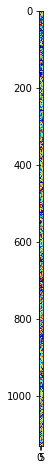

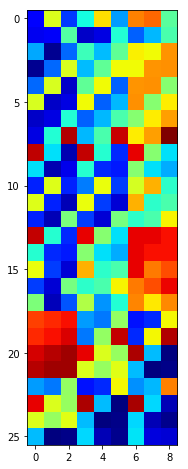

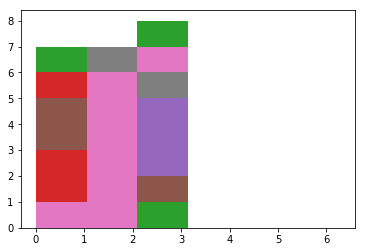

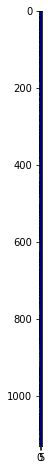

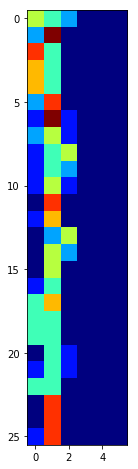

In [82]:
# calculate the descriptors  of each feature found in 'image' and 'query'

# plot the resulted descriptor matrices (use plt.imshow() with jet colormap)
si = feature_detector(source_img,1,0.000275)
qi = feature_detector(query_img,1,0.000275)

si_desc = desc_simple(source_img,si)
qi_desc = desc_simple(query_img,qi)
plt.figure(figsize=(8,8))
plt.imshow(si_desc[0],cmap = 'jet')
plt.show()
plt.figure(figsize=(8,8))
plt.imshow(qi_desc[0],cmap = 'jet')
plt.show()

si_desc_hist = desc_hist(source_img,si)
qi_desc_hist = desc_hist(source_img,qi)
plt.figure(figsize=(8,8))
plt.imshow(si_desc_hist[0],cmap = 'jet')
plt.show()
plt.figure(figsize=(8,8))
plt.imshow(qi_desc_hist[0],cmap = 'jet')
plt.show()

### 3. Matching the features

First, calculate the (Euclidian) distance between each feature in the source-image and each feature in query-image:

$$f(D_1,D_2)=\frac{1}{N}\sum_{i=1}^N{\left({D_1(i)-D_2(i)}\right) }^2$$

Next, for each feature $i$ in img1 ($i=1,...,n_1$)
- find its most similar feature in img2 
- return the ID of the most similar feature $\text{ID}(i)\in\{1,...,n_2\}$ and their distance.


hint: np.max and np.argmax might come handy..

Plot the two images side-by-side. Add the feature points to each image (blue points). Mark the matching features (red points) - if their distance was smaller than a certain threshold.

Play with the parameters until you get a good result.
    

In [122]:
def calc_distances (desc1, desc2):
    
    n1 = desc1.shape[0]
    n2 = desc2.shape[0]
    paired_dist = np.zeros((n1, n2))

    def euclidian_distance(v1, v2):
        return sum([(i1 - i2) ** 2 for i1, i2 in zip(v1, v2)]) / len(v1)

    for i in range(n1):
        for j in range(n2):
            t = zip(desc1[i], desc2[j])
            paired_dist[i, j] = sum([(i1 - i2) ** 2 for i1, i2 in t]) / len(desc1[i])

    ID = np.arange(n1)
    dst = np.array(paired_dist)
    return ID, dst  # ID and dst are vectors of size n1

2


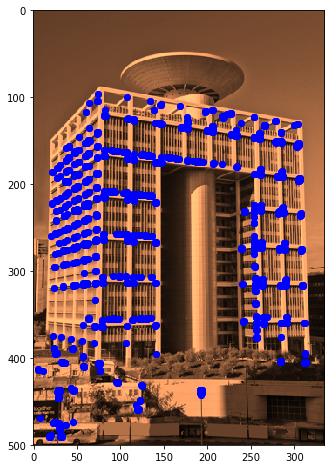

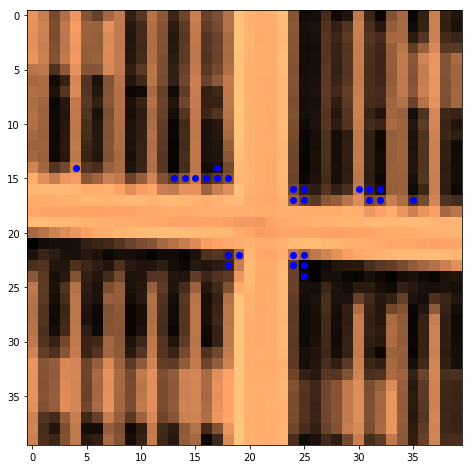

In [140]:

#si_desc_hist
#qi_desc_hist
ID, dst = calc_distances(si_desc_hist[0], qi_desc_hist[0])
match_array = np.zeros(shape=(dst.shape[0],2),dtype=tuple)

si_f = np.nonzero(si)
qi_f = np.nonzero(qi)
print(len(qi_f))


for i in range(dst.shape[0]):
    match_array[i,0] = (si_f[1][i],si_f[0][i])
    match_array[i,1] = (qi_f[1][np.argmin(dst[i])],qi_f[0][np.argmin(dst[i])])


x = []
y = []
xm = []
ym = []


for i in range(len(si_f[0])):
    x.append(si_f[1][i])
    y.append(si_f[0][i])
plt.figure(figsize=(8,8))
plt.imshow(source_img,cmap='copper')
plt.plot(x,y,'ro',color = 'b')
plt.plot(x,y,'ro',color = 'b')
plt.show()

x = []
y = []
for i in range(len(qi_f[0])):
    x.append(qi_f[1][i])
    y.append(qi_f[0][i])

plt.figure(figsize=(8,8))
plt.imshow(query_img,cmap='copper')
plt.plot(x,y,'ro',color = 'b')
plt.show()


# Good luck !